All libraries imported successfully.
Simulated Portfolio: 50,000 policies
Total Gross Written Premium: Rs. 14,217,977,549 (Calibrated to SLIC's Rs. 14,218 Mn)
Simulated 5,014 claims in total.
Total Simulated Claim Amount: Rs. 7,350,000,000.0

Preview of Policy Data:
   PolicyID VehicleType  DriverAge  VehicleAge  SumInsured    Region  \
0         1         Car         26           6     3507521  Northern   
1         2         Van         53           2      731611  Southern   
2         3  Motorcycle         23           0     6115216  Northern   
3         4         Car         41          10     5101989   Eastern   
4         5         Car         43          11     6443675   Western   

   NoClaimBonus  DrivingExperience  Premium  
0           0.3                 39   279898  
1           0.3                 49   402306  
2           0.1                 27   146394  
3           0.3                 39   308372  
4           0.4                 19   313112  

Preview of Claims Data:

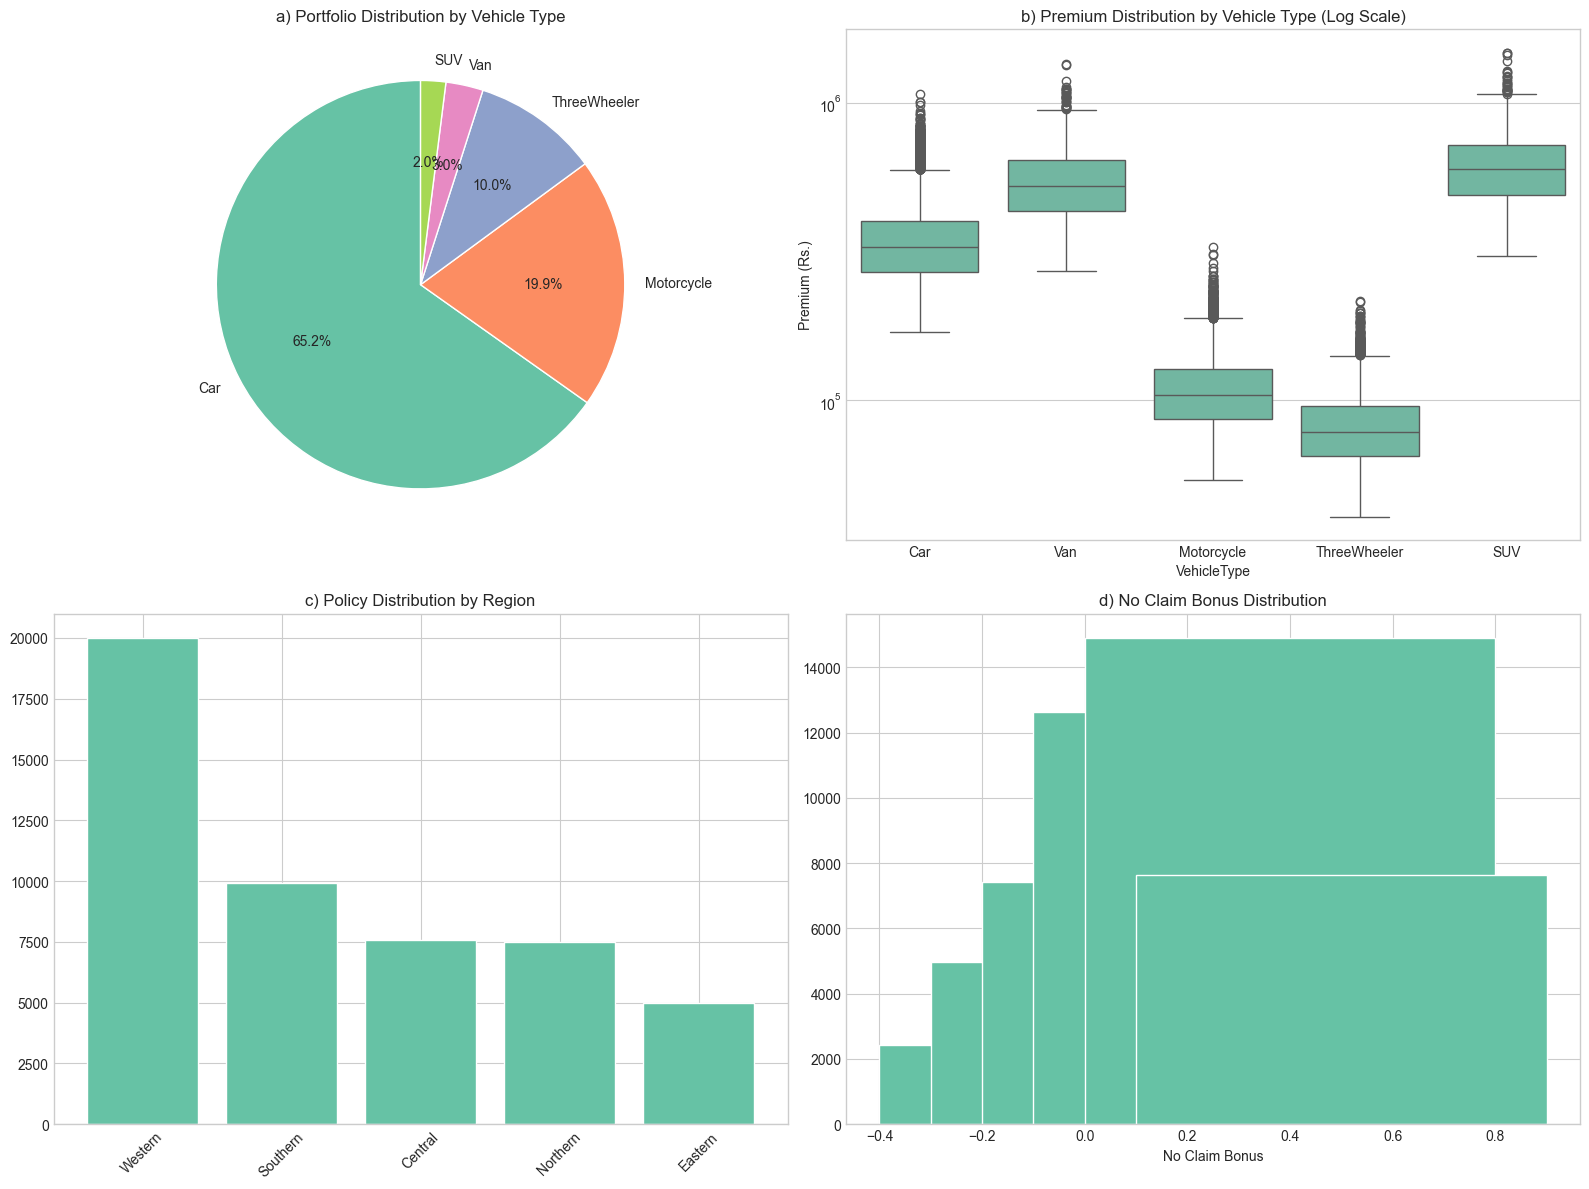

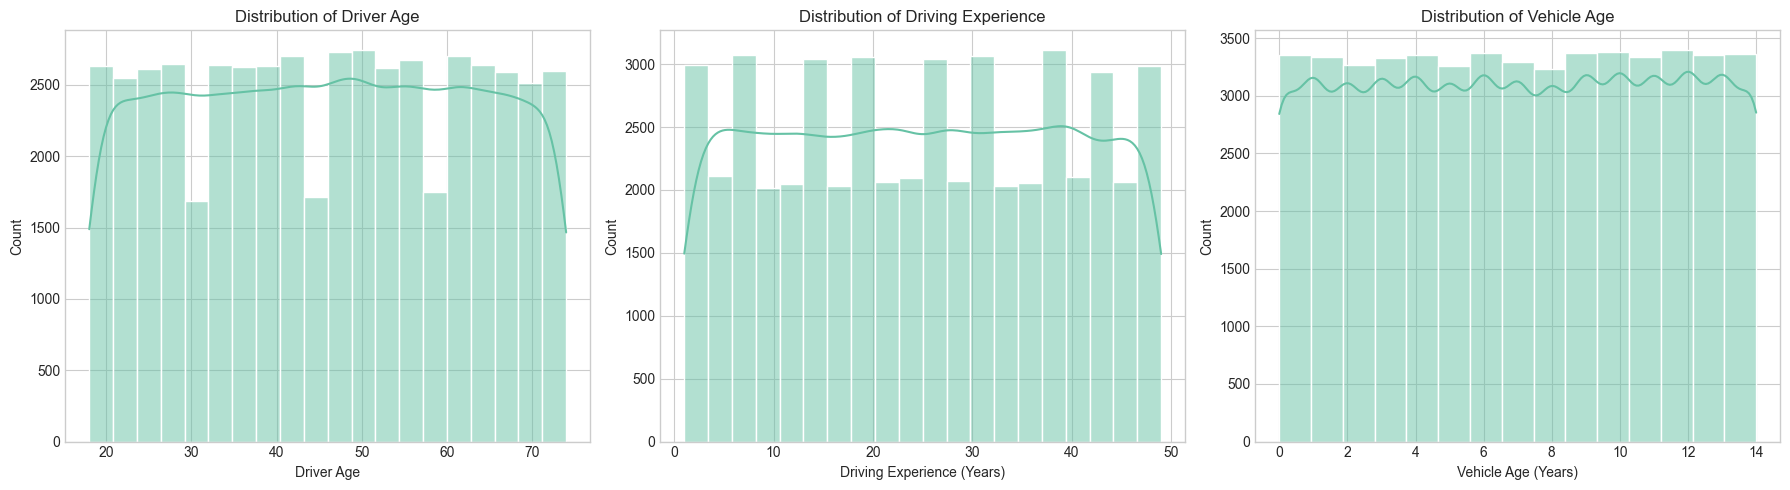

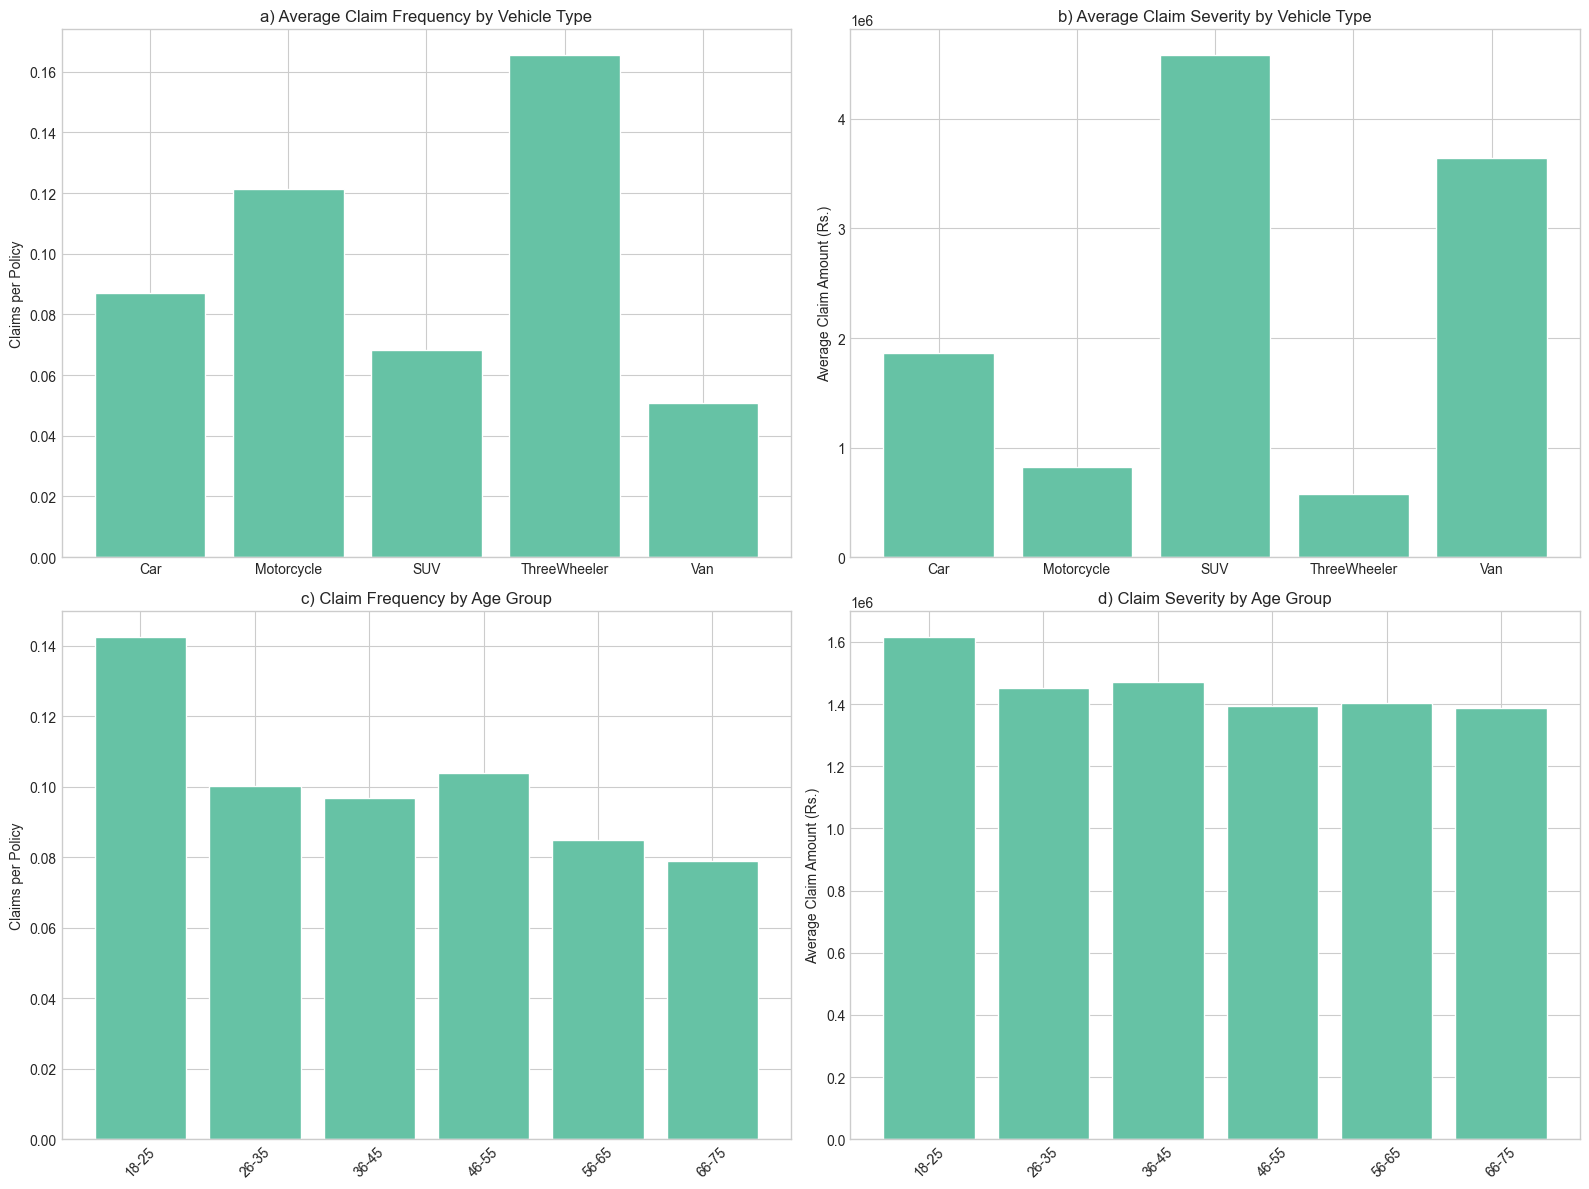

              KEY PORTFOLIO METRICS               
Total Policies:              50,000
Total Claims:                5,014
Earned Premium (Estimate):   Rs. 11,374,382,039
Total Claims Incurred:       Rs. 7,350,000,000
Loss Ratio:                  64.62%
Average Claim Frequency:     0.100 claims per policy
Average Claim Severity:      Rs. 1,465,895
Pure Premium:                Rs. 147,000 per policy

Data prepared for modeling with additional features
Dataset shape: (50000, 17)

Fitting Negative Binomial GLM for Claim Frequency...
                 Generalized Linear Model Regression Results                  
Dep. Variable:             ClaimCount   No. Observations:                50000
Model:                            GLM   Df Residuals:                    49988
Model Family:        NegativeBinomial   Df Model:                           11
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:               

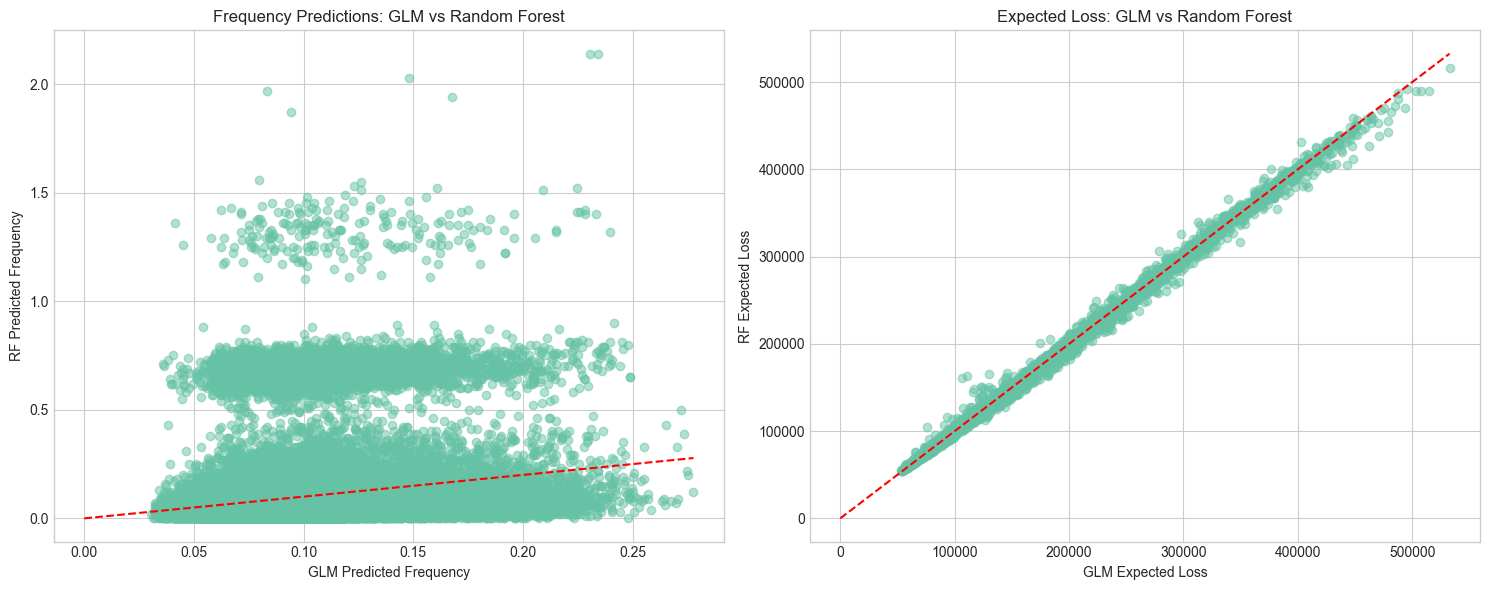


            PRICING ANALYSIS            
Total Expected Loss (Pure Premium): Rs. 7,346,523,037
Total Gross Written Premium:        Rs. 14,217,977,549
Pure Premium Ratio:                 51.67%

Pricing Loadings:
Expense Loading:          46%
Target Profit Margin:     5%
Reinsurance Loading:      10%
Contingency Loading:      3%
Technical Premium Factor: x2.778

Enhanced Premium Comparison by Vehicle Type:
                Premium  TechnicalPremium  ExpectedLoss  \
VehicleType                                               
Car           345824.76         451672.65     162602.15   
Motorcycle    110245.55         276080.87      99389.11   
SUV           628190.93         870675.41     313443.15   
ThreeWheeler   82941.83         266469.02      95928.85   
Van           549009.01         503676.63     181323.59   

              Current vs Technical (%)  Loss Ratio Estimate (%)  
VehicleType                                                      
Car                          30.607378      

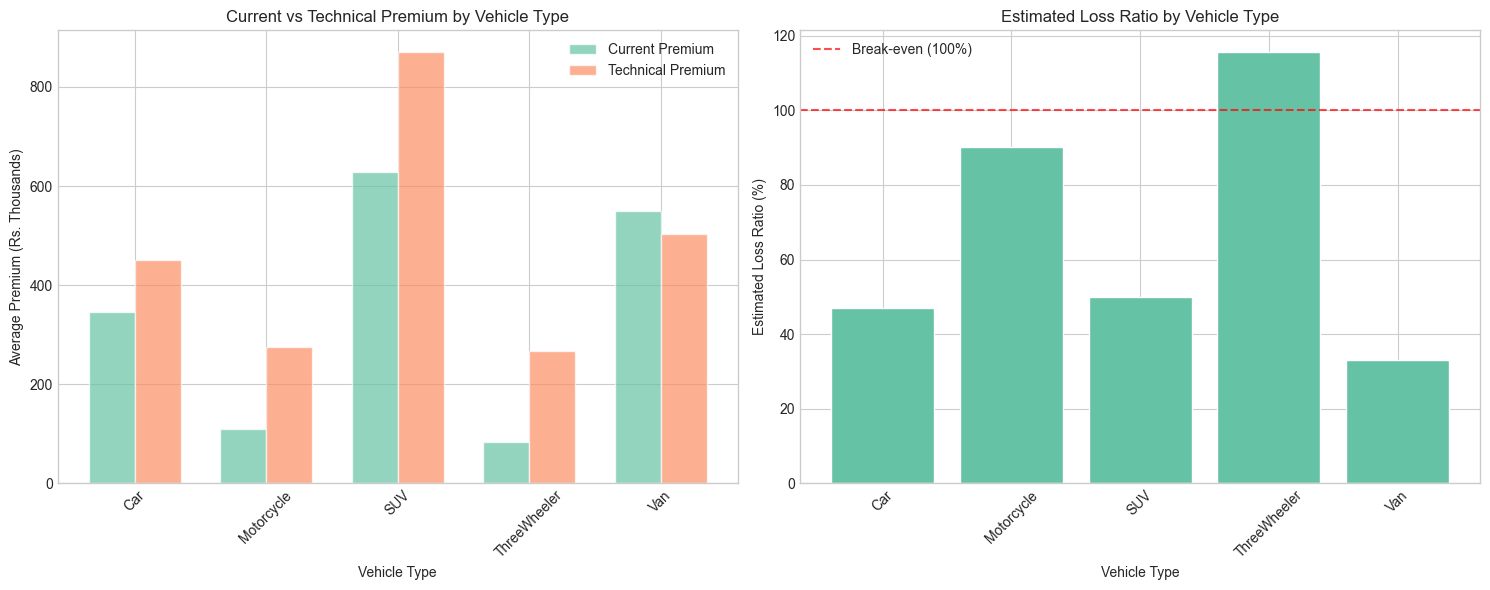


Setting up claims development analysis...
Incurred Loss Triangle (Rs. Mn):
DevelopmentPeriod      0      1     2    3    4     5    6    7    8    9   \
AccidentMonth                                                                
1                  282.42  16.42  0.00  0.0  0.0  0.00  0.0  0.0  0.0  0.0   
2                  338.90   5.48  0.00  0.0  0.0  0.00  0.0  0.0  0.0  0.0   
3                  367.95  16.57  0.00  0.0  0.0  0.00  0.0  0.0  0.0  0.0   
4                  291.38   4.34  0.00  0.0  0.0  0.00  0.0  0.0  0.0  0.0   
5                  311.48   0.00  0.00  0.0  0.0  0.00  0.0  0.0  0.0  0.0   
6                  268.69   6.21  0.00  0.0  0.0  0.00  0.0  0.0  0.0  0.0   
7                  296.90   4.27  0.00  0.0  0.0  0.00  0.0  0.0  0.0  0.0   
8                  265.42   1.56  3.27  0.0  0.0  0.00  0.0  0.0  0.0  0.0   
9                  242.10   4.28  0.00  0.0  0.0  0.00  0.0  0.0  0.0  0.0   
10                 298.28  10.25  0.00  0.0  0.0  0.26  0.0  0.0  

In [14]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")

# Set random seed for reproducibility
np.random.seed(42)

# print("All libraries imported successfully.")

# 1. Simulate Policy Data (50,000 policies for a manageable yet meaningful dataset)
n_policies = 50000

policy_data = pd.DataFrame({
    'PolicyID': range(1, n_policies + 1),
    'VehicleType': np.random.choice(['Car', 'Motorcycle', 'ThreeWheeler', 'Van', 'SUV'],
                                   size=n_policies, p=[0.65, 0.20, 0.10, 0.03, 0.02]),
    'DriverAge': np.random.randint(18, 75, n_policies),
    'VehicleAge': np.random.randint(0, 15, n_policies),
    'SumInsured': np.random.lognormal(mean=14.5, sigma=0.8, size=n_policies).astype(int),
    'Region': np.random.choice(['Western', 'Southern', 'Central', 'Northern', 'Eastern'],
                              n_policies, p=[0.4, 0.2, 0.15, 0.15, 0.1]),
    'NoClaimBonus': np.random.choice([0, 0.1, 0.2, 0.3, 0.4, 0.5],
                                    n_policies, p=[0.05, 0.1, 0.15, 0.25, 0.3, 0.15]),
    'DrivingExperience': np.random.randint(1, 50, n_policies),  # Added feature
})

# Assign a base premium based on risk factors with more realistic calculations
base_premium = np.where(policy_data['VehicleType'] == 'Car', 25000,
               np.where(policy_data['VehicleType'] == 'Motorcycle', 8000,
               np.where(policy_data['VehicleType'] == 'ThreeWheeler', 6000,
               np.where(policy_data['VehicleType'] == 'Van', 40000, 45000))))

# More sophisticated premium factors
age_factor = np.where(policy_data['DriverAge'] < 25, 1.5,
             np.where(policy_data['DriverAge'] > 65, 1.3, 1.0))
vehicle_age_factor = 1 + (policy_data['VehicleAge'] * 0.03)
experience_factor = np.where(policy_data['DrivingExperience'] < 3, 1.2,
                   np.where(policy_data['DrivingExperience'] > 10, 0.9, 1.0))
region_factor = np.where(policy_data['Region'] == 'Western', 1.1,
                        np.where(policy_data['Region'] == 'Central', 1.0, 0.95))

policy_data['Premium'] = (base_premium * age_factor * vehicle_age_factor *
                         experience_factor * region_factor *
                         (1 - policy_data['NoClaimBonus'])).astype(int)

# Scale total premium to match SLIC's reported Motor GWP of ~Rs. 14.2 Bn
total_target_premium = 14218000000  # Rs. 14,218 Mn
current_total_premium = policy_data['Premium'].sum()
scaling_factor = total_target_premium / current_total_premium
policy_data['Premium'] = (policy_data['Premium'] * scaling_factor).astype(int)

print(f"Simulated Portfolio: {n_policies:,} policies")
print(f"Total Gross Written Premium: Rs. {policy_data['Premium'].sum():,} (Calibrated to SLIC's Rs. 14,218 Mn)")

# 2. Simulate Claims based on the policies with more realistic probabilities
claim_probs = {'Car': 0.08, 'Motorcycle': 0.12, 'ThreeWheeler': 0.15, 'Van': 0.06, 'SUV': 0.07}
claim_severity_mean = {'Car': 80000, 'Motorcycle': 35000, 'ThreeWheeler': 25000, 'Van': 150000, 'SUV': 200000}

claims_list = []
claim_id = 1

for _, policy in policy_data.iterrows():
    vt = policy['VehicleType']
    # More realistic claim probability with additional factors
    base_prob = claim_probs[vt]
    age_risk = 1.5 if policy['DriverAge'] < 25 else 0.8 if policy['DriverAge'] > 55 else 1.0
    experience_risk = 1.3 if policy['DrivingExperience'] < 3 else 0.9 if policy['DrivingExperience'] > 15 else 1.0
    vehicle_age_risk = 1 + (policy['VehicleAge'] * 0.02)

    adjusted_prob = base_prob * age_risk * experience_risk * vehicle_age_risk
    n_claims = np.random.poisson(adjusted_prob)

    for _ in range(n_claims):
        # Simulate claim amount with more realistic factors
        mean_claim = claim_severity_mean[vt]
        # Add variation based on driver age and vehicle age
        age_severity_factor = 1.2 if policy['DriverAge'] < 25 else 1.0
        claim_amount = np.random.lognormal(mean=np.log(mean_claim * age_severity_factor), sigma=0.7)

        claims_list.append({
            'ClaimID': claim_id,
            'PolicyID': policy['PolicyID'],
            'ClaimAmount': claim_amount,
            'VehicleType': vt,
            'DriverAge': policy['DriverAge'],
            'VehicleAge': policy['VehicleAge'],
            'DrivingExperience': policy['DrivingExperience']
        })
        claim_id += 1

claims_data = pd.DataFrame(claims_list)
print(f"Simulated {len(claims_data):,} claims in total.")

# Scale claims to a realistic total
current_total_claims = claims_data['ClaimAmount'].sum()
scaling_factor_claims = 7350000000 / current_total_claims  # Rs. 7,350 Mn
claims_data['ClaimAmount'] = claims_data['ClaimAmount'] * scaling_factor_claims

print(f"Total Simulated Claim Amount: Rs. {claims_data['ClaimAmount'].sum():,}")
print("\nPreview of Policy Data:")
print(policy_data.head())
print("\nPreview of Claims Data:")
print(claims_data.head())

# 2.1 - Enhanced Portfolio Composition Analysis
fig, ax = plt.subplots(2, 2, figsize=(16, 12))

# Vehicle Type Distribution
vt_counts = policy_data['VehicleType'].value_counts()
ax[0,0].pie(vt_counts.values, labels=vt_counts.index, autopct='%1.1f%%', startangle=90)
ax[0,0].set_title('a) Portfolio Distribution by Vehicle Type')

# Premium Distribution by Vehicle Type
sns.boxplot(data=policy_data, x='VehicleType', y='Premium', ax=ax[0,1])
ax[0,1].set_yscale('log')
ax[0,1].set_title('b) Premium Distribution by Vehicle Type (Log Scale)')
ax[0,1].set_ylabel('Premium (Rs.)')

# Region Distribution
region_counts = policy_data['Region'].value_counts()
ax[1,0].bar(region_counts.index, region_counts.values)
ax[1,0].set_title('c) Policy Distribution by Region')
ax[1,0].tick_params(axis='x', rotation=45)

# No Claim Bonus Distribution
ncb_counts = policy_data['NoClaimBonus'].value_counts().sort_index()
ax[1,1].bar(ncb_counts.index, ncb_counts.values)
ax[1,1].set_title('d) No Claim Bonus Distribution')
ax[1,1].set_xlabel('No Claim Bonus')

plt.tight_layout()
plt.show()

# 2.2 - Enhanced Driver Profile Analysis
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(data=policy_data, x='DriverAge', bins=20, kde=True, ax=ax[0])
ax[0].set_title('Distribution of Driver Age')
ax[0].set_xlabel('Driver Age')

sns.histplot(data=policy_data, x='DrivingExperience', bins=20, kde=True, ax=ax[1])
ax[1].set_title('Distribution of Driving Experience')
ax[1].set_xlabel('Driving Experience (Years)')

sns.histplot(data=policy_data, x='VehicleAge', bins=15, kde=True, ax=ax[2])
ax[2].set_title('Distribution of Vehicle Age')
ax[2].set_xlabel('Vehicle Age (Years)')

plt.tight_layout()
plt.show()

# 2.3 - Enhanced Claims Analysis
fig, ax = plt.subplots(2, 2, figsize=(16, 12))

# Claim Frequency by Vehicle Type
claim_count_per_policy = claims_data.groupby('PolicyID').size()
policy_with_claims = policy_data.merge(claim_count_per_policy.rename('ClaimCount'),
                                      on='PolicyID', how='left').fillna(0)
freq_by_vt = policy_with_claims.groupby('VehicleType')['ClaimCount'].mean()
ax[0,0].bar(freq_by_vt.index, freq_by_vt.values)
ax[0,0].set_title('a) Average Claim Frequency by Vehicle Type')
ax[0,0].set_ylabel('Claims per Policy')

# Claim Severity by Vehicle Type
sev_by_vt = claims_data.groupby('VehicleType')['ClaimAmount'].mean()
ax[0,1].bar(sev_by_vt.index, sev_by_vt.values)
ax[0,1].set_title('b) Average Claim Severity by Vehicle Type')
ax[0,1].set_ylabel('Average Claim Amount (Rs.)')

# Claim Frequency by Driver Age
age_bins = [18, 25, 35, 45, 55, 65, 75]
age_labels = ['18-25', '26-35', '36-45', '46-55', '56-65', '66-75']
policy_with_claims['AgeGroup'] = pd.cut(policy_with_claims['DriverAge'],
                                       bins=age_bins, labels=age_labels)
freq_by_age = policy_with_claims.groupby('AgeGroup')['ClaimCount'].mean()
ax[1,0].bar(freq_by_age.index, freq_by_age.values)
ax[1,0].set_title('c) Claim Frequency by Age Group')
ax[1,0].set_ylabel('Claims per Policy')
ax[1,0].tick_params(axis='x', rotation=45)

# Claim Severity by Driver Age
claims_data['AgeGroup'] = pd.cut(claims_data['DriverAge'],
                                bins=age_bins, labels=age_labels)
sev_by_age = claims_data.groupby('AgeGroup')['ClaimAmount'].mean()
ax[1,1].bar(sev_by_age.index, sev_by_age.values)
ax[1,1].set_title('d) Claim Severity by Age Group')
ax[1,1].set_ylabel('Average Claim Amount (Rs.)')
ax[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# 2.4 - Enhanced Portfolio Metrics
earned_premium_estimate = policy_data['Premium'].sum() * 0.8  # Assume 80% of GWP is earned
total_claims_incurred = claims_data['ClaimAmount'].sum()
loss_ratio = total_claims_incurred / earned_premium_estimate

# Calculate additional metrics
claim_frequency = policy_with_claims['ClaimCount'].mean()
average_severity = claims_data['ClaimAmount'].mean()
pure_premium = total_claims_incurred / len(policy_data)

print(f"{'='*50}")
print(f"{'KEY PORTFOLIO METRICS':^50}")
print(f"{'='*50}")
print(f"Total Policies:              {len(policy_data):,}")
print(f"Total Claims:                {len(claims_data):,}")
print(f"Earned Premium (Estimate):   Rs. {earned_premium_estimate:,.0f}")
print(f"Total Claims Incurred:       Rs. {total_claims_incurred:,.0f}")
print(f"Loss Ratio:                  {loss_ratio:.2%}")
print(f"Average Claim Frequency:     {claim_frequency:.3f} claims per policy")
print(f"Average Claim Severity:      Rs. {average_severity:,.0f}")
print(f"Pure Premium:                Rs. {pure_premium:,.0f} per policy")
print(f"{'='*50}")

# 3.1 - Prepare Data for Modelling with additional features
modeling_df = policy_data.merge(claim_count_per_policy.rename('ClaimCount'),
                               on='PolicyID', how='left').fillna(0)
modeling_df['Exposure'] = 1
modeling_df['HasClaims'] = (modeling_df['ClaimCount'] > 0).astype(int)

# Create additional features
modeling_df['YoungDriver'] = (modeling_df['DriverAge'] < 25).astype(int)
modeling_df['SeniorDriver'] = (modeling_df['DriverAge'] > 65).astype(int)
modeling_df['NewVehicle'] = (modeling_df['VehicleAge'] < 3).astype(int)
modeling_df['OldVehicle'] = (modeling_df['VehicleAge'] > 10).astype(int)
modeling_df['InexperiencedDriver'] = (modeling_df['DrivingExperience'] < 3).astype(int)

print("\nData prepared for modeling with additional features")
print(f"Dataset shape: {modeling_df.shape}")

# 3.2 - Enhanced Frequency Model with Negative Binomial (handles overdispersion better)
print("\nFitting Negative Binomial GLM for Claim Frequency...")
freq_model = smf.glm('ClaimCount ~ VehicleType + DriverAge + VehicleAge + DrivingExperience + Region',
                    data=modeling_df,
                    family=sm.families.NegativeBinomial(),
                    offset=np.log(modeling_df['Exposure'])).fit()

print(freq_model.summary())

# Calculate frequency predictions
modeling_df['PredictedFrequency'] = freq_model.predict(modeling_df)

# 3.3 - Enhanced Severity Model
claims_for_sev_model = modeling_df[modeling_df['ClaimCount'] > 0].copy()
avg_claim_sev = claims_data.groupby('PolicyID')['ClaimAmount'].mean()
claims_for_sev_model = claims_for_sev_model.merge(avg_claim_sev.rename('AvgClaimAmount'),
                                                 on='PolicyID', how='left')

print("\nFitting Gamma GLM for Claim Severity...")
sev_model = smf.glm('AvgClaimAmount ~ VehicleType + DriverAge + VehicleAge',
                   data=claims_for_sev_model,
                   family=sm.families.Gamma(link=sm.families.links.log())).fit()
print(sev_model.summary())

# Calculate severity predictions for all policies
modeling_df['PredictedSeverity'] = sev_model.predict(modeling_df)
modeling_df['ExpectedLoss'] = modeling_df['PredictedFrequency'] * modeling_df['PredictedSeverity']

print("\nExpected Loss per Policy by Vehicle Type:")
expected_loss_by_type = modeling_df.groupby('VehicleType')['ExpectedLoss'].mean().round(2)
print(expected_loss_by_type)

# 3.4 - Machine Learning Approach (Random Forest) for comparison
print("\nTraining Random Forest model for comparison...")

# Prepare features for ML
ml_df = modeling_df.copy()
categorical_cols = ['VehicleType', 'Region']
ml_df = pd.get_dummies(ml_df, columns=categorical_cols, drop_first=True)

# Features for ML model
feature_cols = [col for col in ml_df.columns if col not in
               ['PolicyID', 'ClaimCount', 'Exposure', 'HasClaims', 'AvgClaimAmount',
                'PredictedFrequency', 'PredictedSeverity', 'ExpectedLoss']]

X = ml_df[feature_cols]
y_freq = ml_df['ClaimCount']
y_sev = ml_df['ExpectedLoss']

# Train-test split
X_train, X_test, y_freq_train, y_freq_test = train_test_split(X, y_freq, test_size=0.2, random_state=42)
_, _, y_sev_train, y_sev_test = train_test_split(X, y_sev, test_size=0.2, random_state=42)

# Random Forest for frequency
rf_freq = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_freq.fit(X_train, y_freq_train)
ml_df['RF_PredictedFrequency'] = rf_freq.predict(X)

# Random Forest for severity
rf_sev = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_sev.fit(X_train, y_sev_train)
ml_df['RF_ExpectedLoss'] = rf_sev.predict(X)

print("Random Forest models trained successfully")

# 4. Model Validation and Comparison
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# GLM vs RF Frequency Comparison
ax[0].scatter(modeling_df['PredictedFrequency'], ml_df['RF_PredictedFrequency'], alpha=0.5)
ax[0].plot([0, modeling_df['PredictedFrequency'].max()], [0, modeling_df['PredictedFrequency'].max()], 'r--')
ax[0].set_xlabel('GLM Predicted Frequency')
ax[0].set_ylabel('RF Predicted Frequency')
ax[0].set_title('Frequency Predictions: GLM vs Random Forest')

# GLM vs RF Severity Comparison
ax[1].scatter(modeling_df['ExpectedLoss'], ml_df['RF_ExpectedLoss'], alpha=0.5)
ax[1].plot([0, modeling_df['ExpectedLoss'].max()], [0, modeling_df['ExpectedLoss'].max()], 'r--')
ax[1].set_xlabel('GLM Expected Loss')
ax[1].set_ylabel('RF Expected Loss')
ax[1].set_title('Expected Loss: GLM vs Random Forest')

plt.tight_layout()
plt.show()

# 5.1 - Calculate Pure Premium and Technical Premium
total_expected_loss = modeling_df['ExpectedLoss'].sum()
total_premium = modeling_df['Premium'].sum()
pure_premium_ratio = total_expected_loss / total_premium

print(f"\n{'='*40}")
print(f"{'PRICING ANALYSIS':^40}")
print(f"{'='*40}")
print(f"Total Expected Loss (Pure Premium): Rs. {total_expected_loss:,.0f}")
print(f"Total Gross Written Premium:        Rs. {total_premium:,.0f}")
print(f"Pure Premium Ratio:                 {pure_premium_ratio:.2%}")

# Enhanced pricing factors
expense_loading = 0.46  # 46% of premium goes to expenses
target_profit_margin = 0.05  # Target 5% profit margin
reinsurance_loading = 0.10  # 10% loading for reinsurance costs
contingency_loading = 0.03  # 3% for unexpected events

# Technical premium calculation
technical_premium_factor = 1 / (1 - expense_loading - target_profit_margin -
                               reinsurance_loading - contingency_loading)
modeling_df['TechnicalPremium'] = modeling_df['ExpectedLoss'] * technical_premium_factor

print(f"\nPricing Loadings:")
print(f"Expense Loading:          {expense_loading:.0%}")
print(f"Target Profit Margin:     {target_profit_margin:.0%}")
print(f"Reinsurance Loading:      {reinsurance_loading:.0%}")
print(f"Contingency Loading:      {contingency_loading:.0%}")
print(f"Technical Premium Factor: x{technical_premium_factor:.3f}")

# 6.1 - Enhanced Premium Comparison
comparison_df = modeling_df.groupby('VehicleType').agg({
    'Premium': 'mean',
    'TechnicalPremium': 'mean',
    'ExpectedLoss': 'mean'
}).round(2)
comparison_df['Current vs Technical (%)'] = ((comparison_df['TechnicalPremium'] - comparison_df['Premium']) / comparison_df['Premium']) * 100
comparison_df['Loss Ratio Estimate (%)'] = (comparison_df['ExpectedLoss'] / comparison_df['Premium']) * 100

print("\nEnhanced Premium Comparison by Vehicle Type:")
print(comparison_df)

# 6.2 - Premium Adequacy Visualization
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Current vs Technical Premium
vehicle_types = comparison_df.index
x_pos = np.arange(len(vehicle_types))
width = 0.35

ax[0].bar(x_pos - width/2, comparison_df['Premium']/1000, width, label='Current Premium', alpha=0.7)
ax[0].bar(x_pos + width/2, comparison_df['TechnicalPremium']/1000, width, label='Technical Premium', alpha=0.7)
ax[0].set_xlabel('Vehicle Type')
ax[0].set_ylabel('Average Premium (Rs. Thousands)')
ax[0].set_title('Current vs Technical Premium by Vehicle Type')
ax[0].set_xticks(x_pos)
ax[0].set_xticklabels(vehicle_types)
ax[0].legend()
ax[0].tick_params(axis='x', rotation=45)

# Loss Ratio by Vehicle Type
ax[1].bar(comparison_df.index, comparison_df['Loss Ratio Estimate (%)'])
ax[1].axhline(y=100, color='r', linestyle='--', alpha=0.7, label='Break-even (100%)')
ax[1].set_xlabel('Vehicle Type')
ax[1].set_ylabel('Estimated Loss Ratio (%)')
ax[1].set_title('Estimated Loss Ratio by Vehicle Type')
ax[1].tick_params(axis='x', rotation=45)
ax[1].legend()

plt.tight_layout()
plt.show()

# 7.1 - Enhanced Reserving with Development Triangles
print("\nSetting up claims development analysis...")

# Create more realistic development patterns
accident_months = pd.date_range(start='2023-01-01', end='2024-12-01', freq='MS')
claims_data['AccidentMonth'] = np.random.choice(accident_months, size=len(claims_data))

# More realistic reporting delay (lognormal with different parameters by vehicle type)
delay_params = {
    'Car': (1.8, 0.8), 'Motorcycle': (1.2, 0.6), 'ThreeWheeler': (1.0, 0.5),
    'Van': (2.0, 1.0), 'SUV': (1.5, 0.7)
}

claims_data['ReportingDelay'] = 0
for vt, (mean, sigma) in delay_params.items():
    mask = claims_data['VehicleType'] == vt
    size = mask.sum()
    claims_data.loc[mask, 'ReportingDelay'] = np.random.lognormal(
        mean=mean, sigma=sigma, size=size
    ).astype(int)

claims_data['ReportedMonth'] = claims_data['AccidentMonth'] + pd.to_timedelta(
    claims_data['ReportingDelay'], unit='D'
)

# 7.2 - Create Enhanced Incurred Loss Triangle
claims_2024 = claims_data[claims_data['AccidentMonth'].dt.year == 2024].copy()
max_dev_period = 12

# Create development periods in months
claims_2024['DevelopmentPeriod'] = (
    (claims_2024['ReportedMonth'].dt.to_period('M') -
     claims_2024['AccidentMonth'].dt.to_period('M')).apply(lambda x: x.n)
)

# Filter to relevant development periods and ensure we have data
claims_2024 = claims_2024[claims_2024['DevelopmentPeriod'] < max_dev_period]

# Create the triangle with all possible development periods
all_dev_periods = list(range(max_dev_period))
incurred_triangle = claims_2024.pivot_table(
    index=claims_2024['AccidentMonth'].dt.month,
    columns='DevelopmentPeriod',
    values='ClaimAmount',
    aggfunc='sum',
    fill_value=0
)

# Ensure all development periods are present (0 through max_dev_period-1)
for dev_period in all_dev_periods:
    if dev_period not in incurred_triangle.columns:
        incurred_triangle[dev_period] = 0

# Reindex columns to ensure proper order
incurred_triangle = incurred_triangle.reindex(columns=all_dev_periods)

print("Incurred Loss Triangle (Rs. Mn):")
print((incurred_triangle / 1e6).round(2))

# 7.3 - Enhanced Chain Ladder with Validation
cumulative_triangle = incurred_triangle.cumsum(axis=1)

# Calculate age-to-age factors with safe bounds checking
ata_factors = {}
available_columns = len(cumulative_triangle.columns)

for i in range(1, min(max_dev_period, available_columns)):
    # Only calculate factors if we have enough data
    if i < available_columns and (available_columns - i) > 0:
        numerator = cumulative_triangle.iloc[:(available_columns - i), i].sum()
        denominator = cumulative_triangle.iloc[:(available_columns - i), i-1].sum()

        if denominator > 0 and not np.isnan(denominator):
            ata_factors[i] = numerator / denominator
        else:
            ata_factors[i] = 1.0  # Default factor
    else:
        ata_factors[i] = 1.0  # Default factor

print(f"\nAge-to-Age Factors: {ata_factors}")

# Project ultimate claims - only for columns that exist
full_triangle = cumulative_triangle.copy()

# Extend the triangle with additional columns if needed
for col in range(available_columns, max_dev_period):
    full_triangle[col] = 0  # Add new column initialized with zeros

# Now project the values
for col in range(available_columns, max_dev_period):
    prev_col = col - 1
    factor = ata_factors.get(prev_col, 1.0)  # Use default factor 1.0 if not found

    for row in range(0, max_dev_period - col):
        if row < len(full_triangle) and prev_col in full_triangle.columns:
            current_value = full_triangle.iloc[row, prev_col]
            full_triangle.iloc[row, col] = current_value * factor

# Calculate IBNR and other reserves
if available_columns > 0:
    latest_dev_column = min(available_columns - 1, max_dev_period - 1)
    paid_to_date = cumulative_triangle.iloc[:, latest_dev_column].sum()
    total_ultimate_claims = full_triangle.iloc[:, -1].sum()
    ibnr_estimate = total_ultimate_claims - paid_to_date
else:
    paid_to_date = 0
    total_ultimate_claims = 0
    ibnr_estimate = 0

print(f"\n{'='*40}")
print(f"{'RESERVING ANALYSIS':^40}")
print(f"{'='*40}")
print(f"Paid Claims to Date:      Rs. {paid_to_date:,.0f}")
print(f"Estimated IBNR Reserve:   Rs. {ibnr_estimate:,.0f}")
print(f"Total Ultimate Claims:    Rs. {total_ultimate_claims:,.0f}")
if total_ultimate_claims > 0:
    print(f"Reserve Adequacy:         {ibnr_estimate/total_ultimate_claims:.1%} of ultimate claims")
else:
    print(f"Reserve Adequacy:         N/A (no claims data)")


# 8. Risk Segmentation and Portfolio Optimization
print(f"\n{'='*50}")
print(f"{'RISK SEGMENTATION ANALYSIS':^50}")
print(f"{'='*50}")

# Segment policies by risk level
modeling_df['RiskSegment'] = pd.qcut(modeling_df['ExpectedLoss'],
                                    q=4,
                                    labels=['Low Risk', 'Medium-Low Risk', 'Medium-High Risk', 'High Risk'])

risk_segment_analysis = modeling_df.groupby('RiskSegment').agg({
    'PolicyID': 'count',
    'Premium': 'mean',
    'ExpectedLoss': 'mean',
    'TechnicalPremium': 'mean',
    'ClaimCount': 'mean'
}).round(2)

risk_segment_analysis['Policies (%)'] = (risk_segment_analysis['PolicyID'] / len(modeling_df) * 100)
risk_segment_analysis['Profitability Gap'] = risk_segment_analysis['Premium'] - risk_segment_analysis['ExpectedLoss']

print("Risk Segment Analysis:")
print(risk_segment_analysis)

# 9. Recommendations and Insights
print(f"\n{'='*60}")
print(f"{'KEY INSIGHTS AND RECOMMENDATIONS':^60}")
# print(f"{'='=*60}")

# Calculate overall portfolio metrics
current_profitability = (modeling_df['Premium'].sum() - modeling_df['ExpectedLoss'].sum()) / modeling_df['Premium'].sum()
recommended_profitability = (modeling_df['TechnicalPremium'].sum() - modeling_df['ExpectedLoss'].sum()) / modeling_df['TechnicalPremium'].sum()

print(f"Current Portfolio Profitability:    {current_profitability:.2%}")
print(f"Recommended Portfolio Profitability: {recommended_profitability:.2%}")

# Identify problematic segments
problem_segments = comparison_df[comparison_df['Loss Ratio Estimate (%)'] > 100]
if not problem_segments.empty:
    print(f"\nUnderpriced Segments (Loss Ratio > 100%):")
    for vt, row in problem_segments.iterrows():
        print(f"  - {vt}: {row['Loss Ratio Estimate (%)']:.1f}% loss ratio")

# Premium adjustment recommendations
print(f"\nPremium Adjustment Recommendations:")
for vt in comparison_df.index:
    current_premium = comparison_df.loc[vt, 'Premium']
    technical_premium = comparison_df.loc[vt, 'TechnicalPremium']
    adjustment_pct = ((technical_premium - current_premium) / current_premium) * 100

    if abs(adjustment_pct) > 5:  # Only suggest adjustments > 5%
        direction = "increase" if adjustment_pct > 0 else "decrease"
        print(f"  - {vt}: {direction} premiums by {abs(adjustment_pct):.1f}%")

print(f"\nReserving Recommendation:")
print(f"  - Maintain IBNR reserve of Rs. {ibnr_estimate:,.0f} for 2024 claims")

print(f"\n{'Analysis completed successfully!':^60}")